### <span style="color:rgb(199,21,11)">Optimization for Machine Learning</span>

### <span style="color:rgb(199,21,11)">Master 2 IASD </span>


# <span style="color:rgb(199,21,11)">Project - Mohamed Ali SRIR</span>

# <span style="color:rgb(199,21,11)">Imports</span>

In [4]:
#Import scikit tool to load the dataset
from sklearn.datasets import load_svmlight_file

import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

# <span style="color:rgb(199,21,11)">Part 1 - Problem Data</span>

## <span style="color:rgb(11, 55, 199)"> Question 1</span>

The libsvm format is particular and allows a compact representation of potentially sparse datasets where we only keep non-zero values and there associated feature column, in this format :

label column:value column:value ...

In [5]:
# Path to the dataset
file_path = "data/a9a"
# test others like (But not tested)
# file_path = "data/covtype.libsvm.binary.scale"

# Load the data
A, y = load_svmlight_file(file_path)

# Format A to a matrix and y to {0,1} values
A = A.toarray()
y = (y-y.min())/(y.max()-y.min())

# Check the shape of data
print(f"Features shape: {A.shape}, Labels shape: {y.shape}")


Features shape: (32561, 123), Labels shape: (32561,)


As we can see below the matrix is very sparse.

In [6]:
total = A.shape[0]*A.shape[1]
zero_portion = ((A == 0).sum()/total)*100
print(" %.2f%% of values are null"%zero_portion)


 88.72% of values are null


In the correlation matrix below, we observe a few off-diagonal correlations that highlight meaningful relationships between features. A small number of off-diagonal values are very close to 1, suggesting potentially redundant features. However, these cases are minimal and do not require any action.

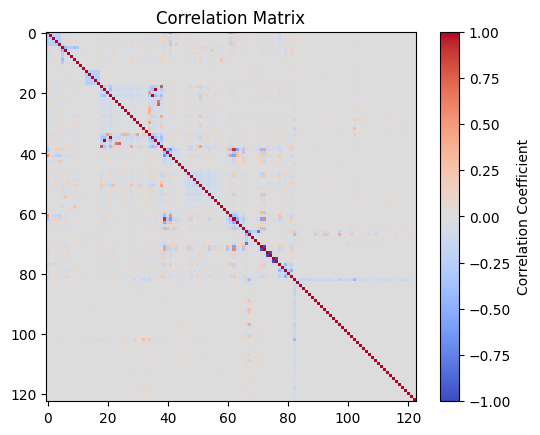

In [7]:
correlation_matrix = np.corrcoef(A.T)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
plt.show()

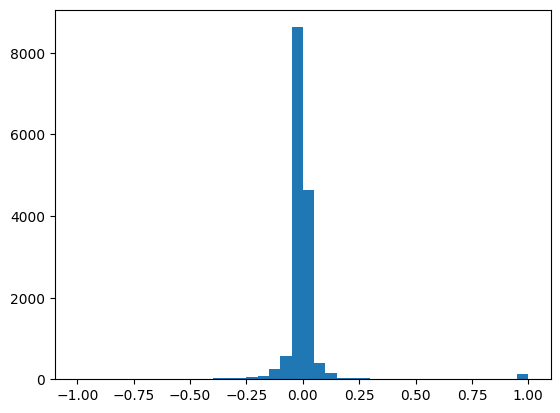

In [8]:
plt.hist(correlation_matrix.flatten(),bins = 40)
plt.show()

# <span style="color:rgb(199,21,11)">Part 2 - Optimization problems</span>

## <span style="color:rgb(11, 55, 199)"> Question 2</span>

Let's first define the function and the formal gradient expression :

In [9]:
def f_i(x,a_i,y_i):
    return (y_i-1/(1+torch.exp(-torch.dot(a_i, x))))**2

def gradient_fi(x,a_i, y_i):
    exp_term = torch.exp(torch.dot(a_i, x))  # Compute exp(a_i^T x)
    numerator = 2 * exp_term * (exp_term * (y_i - 1) + y_i)
    denominator = (1 + exp_term) ** 3
    grad = - (numerator / denominator) * a_i
    return grad

In order to estimate the gradient with autograd we need a forward pass, let's choose a random value of x and a random line (feature and label) in the dataset.

In [10]:
# Creating a random array with values in [-1,1], y
x = torch.rand(A.shape[1],requires_grad=True)

# Select a random data point
i = np.random.randint(A.shape[0])
a_i = torch.tensor(A[i],dtype=torch.float32)
y_i = y[i]

# We need a forward pass to call backward
f = f_i(x,a_i,y_i)
f.backward()

Now let's compare it to the formal gradient value.

In [11]:
#Compute the autograd value
autograd_val = x.grad

#Compute the formal grad
formal_gradient_fi = gradient_fi(x,a_i,y_i)

print("Distance between gradients:", torch.norm(autograd_val - formal_gradient_fi).detach().numpy())

Distance between gradients: 1.4037448e-10


# <span style="color:rgb(199,21,11)">Part 3 - First-order algorithms</span>

The function $ f_i(x) = g_i(a^T x) $, where $ x \in \mathbb{R}^d $ and $ a \in \mathbb{R}^d $, can be differentiated with respect to $ x $ using the chain rule.

We get that :

- The first derivative (gradient) is: $\nabla f_i(x) = g_i'(a^T x) \cdot a$
- The second derivative (Hessian) is: $\nabla^2 f_i(x) = g_i''(a^T x) \cdot a a^T$

With :
$
g_i(z) = \left( y_i - \frac{1}{1 + e^{-z}} \right)^2
$



We can observe in the GeoGebra plot below (which can be reproduced using the provided `.ggb` file) that for both $ y_i = 0 $ or $ y_i = 1 $, the function $ g_i $ is not convex. This conclusion arises because $ g_i''(z) $ takes both positive and negative values. However, $ g_i $ is $ L $-smooth since $ g_i''(z) $ is bounded, with $ L $ being the maximum value of $ |g_i''(z) |$, approximately:

$$
L = \max | g_i''(z)| \approx 0.1541.
$$

As a result, the function $ f_i $ is **not convex**, but it is $ L $-smooth. The smoothness constant $ L $ for $ f_i $ is determined by:

$$
L = \max |g_i''(z)| \cdot \max \lambda(a a^T),
$$

where $ \max \lambda(a a^T) $ is the largest eigenvalue of the matrix $ a a^T $.

![alt text](plots/derive_seconde.png "Title")

## <span style="color:rgb(11, 55, 199)"> Question 3 (GD)</span>

In the case of Gradient descent, what we want is :

$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x})
    := \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x})
$$

as before the function is not convex but it is L-smooth, with L being :

$$
L = \max |g_i''(z)| \cdot \max \lambda (\frac{1}{n} \sum_{i=1}^n  a_i a_i^T)
$$

According to the course, with a constant step-size of $\frac{1}{L}$ we have a convergence rate of $O(\frac{1}{\sqrt{T}})$ to a second-order critical point for almost any initial position $x_0$.

In order to do experiments, let's provide a vectorized version of $f$ and $\nabla f$ :

In [12]:
x = torch.ones(A.shape[1],dtype=torch.float32,requires_grad=True)
A = torch.tensor(A,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.float32)

def f(x,A,y):
    return ((y-1/(1+torch.exp(-A @ x)))**2).mean()

def gradient_f(x,A, y):
    exp_term = torch.exp(A @ x)
    numerator = 2 * exp_term * (exp_term * (y - 1) + y)
    denominator = (1 + exp_term) ** 3
    g_prime = (- (numerator / denominator)).unsqueeze(1)
    grad = torch.mul(A, g_prime)
    return grad.mean(axis=0)

Compare again gradient_f with autograd

In [13]:
# Creating a random array with values in [-1,1], y
x = torch.rand(A.shape[1],requires_grad=True)

# We need a forward pass to call backward
eval_f = f(x,A, y)
eval_f.backward()

#Compute the autograd value
autograd_val = x.grad

#Compute the formal grad
formal_gradient_f = gradient_f(x,A, y)

print("Distance between gradients:", torch.norm(autograd_val - formal_gradient_f).detach().numpy())

Distance between gradients: 1.4927174e-08


Let's now estimate L

In [14]:
batch_aat = torch.bmm(A.unsqueeze(2),A.unsqueeze(1))

In [15]:
candidates = torch.linalg.eigh(batch_aat.mean(axis=0))[0]

In [16]:
L = 0.1541 * torch.abs(candidates).max().item()
L

0.9689315109729766

Let's implement GD ! (We will add batch_size and scaling option so we don't rewrite eveything from scratch for SG and AdaGrad)

In [17]:
# Gradient descent
def gd_loop(x0,stepsize, n_iter=1000, batch_size=None,scaling=None,l1_reg = None,verbose=False):

    ############
    # Initialization

    # History of function values
    objvals = []

    # History of gradient norms
    ngvals = []

    # Initial value of the incumbent, a.k.a. current iterate
    x = x0.clone()
    n = A.shape[0]
    d = A.shape[1]

    if scaling:
        eps=1/(2 *(n ** (0.5))) # To avoid numerical issues
        v = torch.zeros(d)

    # Initial function value
    if batch_size :
        batch_i = np.random.choice(n,batch_size).tolist()
        A_b,y_b = A[batch_i],y[batch_i]
    else :
        A_b,y_b = A,y

    obj = f(x,A_b,y_b)
    objvals.append(obj.item())

    # Initial gradient
    g = gradient_f(x,A_b,y_b)
    ng = torch.norm(g)
    ngvals.append(ng)

    # Plot initial values
    if verbose:
        print("Gradient descent:")
        print(' | '.join([name.center(8) for name in ["epoch", "step","fval","stepsize"]]))

    ####################
    # Main loop
    if verbose : iterator = range(n_iter)
    else : iterator = tqdm(range(n_iter))

    for k in iterator:
        if batch_size : steps = n//batch_size
        else : steps=1
        for l in range(steps):
            if scaling:
                v = v + g*g
                g = g/(torch.sqrt(v+eps))

            # Perform the gradient descent iteration using the stepsize s and the gradient g
            x = x - stepsize*g

            if l1_reg :
                for i in range(d):
                    threshold = stepsize*l1_reg
                    if x[i] < -threshold:
                        x[i] = x[i]+threshold
                    elif x[i] > threshold:
                        x[i] = x[i]-threshold
                    else:
                        x[i] = 0

            # Plot relevant information
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%d" % l).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % stepsize).rjust(8)]))

            # Compute values associated with the next iterate
            if batch_size :
                batch_i = np.random.choice(n,batch_size).tolist()
                A_b,y_b = A[batch_i],y[batch_i]
            else :
                A_b,y_b = A,y
            g = gradient_f(x,A_b,y_b)

        obj = f(x,A_b,y_b)
        ng = torch.norm(g)
        objvals.append(obj.item())
        ngvals.append(ng.item())

    # End main loop
    ######################

    # Outputs
    x_output = x.clone()
    return x_output, objvals, ngvals

In [18]:
x0 = torch.rand(A.shape[1],requires_grad=False)
steps = [100/L,10/L,5/L,2/L,1/L,0.5/L]

gd_results_dict = {}

for step in steps :
    print("Compute for step %0.2f"%step)
    gd_results_dict[step] = gd_loop(x0,step,n_iter=700,verbose=False)
    print("Final objective value for step - %0.2f"%step,gd_results_dict[step][1][-1])

Compute for step 103.21


100%|██████████| 700/700 [00:13<00:00, 53.31it/s]


Final objective value for step - 103.21 0.24080955982208252
Compute for step 10.32


100%|██████████| 700/700 [00:07<00:00, 89.09it/s]


Final objective value for step - 10.32 0.11063503473997116
Compute for step 5.16


100%|██████████| 700/700 [00:08<00:00, 80.12it/s]


Final objective value for step - 5.16 0.1039612889289856
Compute for step 2.06


100%|██████████| 700/700 [00:08<00:00, 83.32it/s]


Final objective value for step - 2.06 0.10454770177602768
Compute for step 1.03


100%|██████████| 700/700 [00:07<00:00, 89.36it/s]


Final objective value for step - 1.03 0.10586157441139221
Compute for step 0.52


100%|██████████| 700/700 [00:08<00:00, 81.95it/s]

Final objective value for step - 0.52 0.10935209691524506


We can see below that $5/L$ is a very good tradeoff, it converges fast, but unlike $10/L$ it safely and robustely converges towards what seems to be the best minimum we reached.

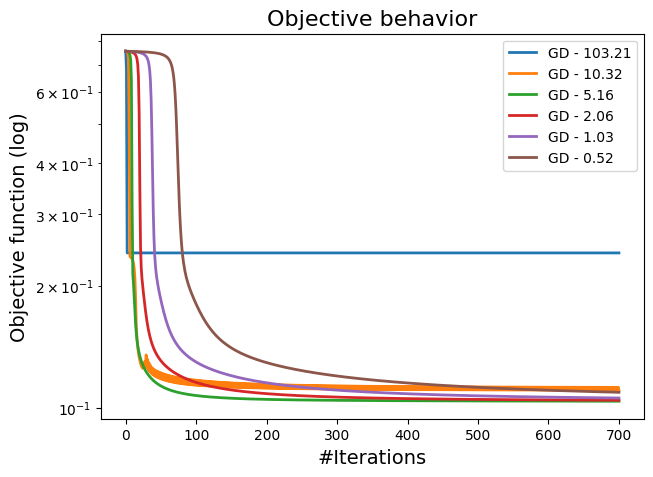

In [19]:
plt.figure(figsize=(7, 5))
for k,v in gd_results_dict.items():
    plt.semilogy(v[1], label="GD - %0.2f"%k, lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

best_gd = gd_results_dict[5/L]

According to the course (Non-convex Optimization Lecture Notes), we have an upper bound convergence rate for the norm of the gradient, which is in $O(\frac{1}{\sqrt{T}})$ for stepsize smaller than $1/L$. It is clearly coherent with our results.

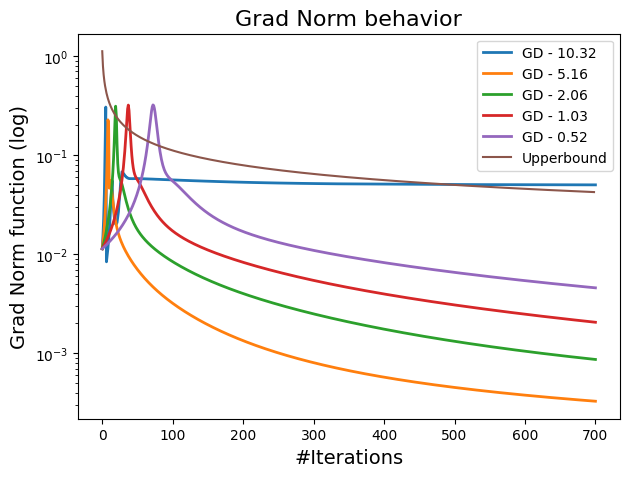

In [20]:
plt.figure(figsize=(7, 5))
for k,v in gd_results_dict.items():
    ### Hiding 100/L for scaling only
    if k< 100 : plt.semilogy(v[2], label="GD - %0.2f"%k, lw=2)

values = gd_results_dict[1/L][1]
plt.semilogy(np.sqrt(2*L*(values[0]-values[-1]))/np.sqrt(np.arange(1,700)),label = "Upperbound")
plt.title("Grad Norm behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Grad Norm function (log)", fontsize=14)
plt.legend()
plt.show()

## <span style="color:rgb(11, 55, 199)"> Question 4 (SG)</span>

The gd_loop code and especially (f and gradient_f) have been design to handle seemlessly different batch sizes taking the whole dataset by default.

We coherently have a noisy convergence towards the same minimum as GD.

In [21]:
#x0 = torch.rand(A.shape[1],requires_grad=False)
steps = [100/L,10/L,5/L,2/L,1/L,0.5/L]

sgd_results_dict = {}

for step in steps :
    print("Compute for step %0.2f"%step)
    sgd_results_dict[step] = gd_loop(x0,step,n_iter=700,batch_size=1000,verbose=False)
    print("Final objective value for step - %0.2f"%step,sgd_results_dict[step][1][-1])

Compute for step 103.21


100%|██████████| 700/700 [00:31<00:00, 21.95it/s]


Final objective value for step - 103.21 0.23599998652935028
Compute for step 10.32


100%|██████████| 700/700 [00:28<00:00, 24.67it/s]


Final objective value for step - 10.32 0.10651115328073502
Compute for step 5.16


100%|██████████| 700/700 [00:28<00:00, 24.69it/s]


Final objective value for step - 5.16 0.1063636839389801
Compute for step 2.06


100%|██████████| 700/700 [00:28<00:00, 24.75it/s]


Final objective value for step - 2.06 0.10389546304941177
Compute for step 1.03


100%|██████████| 700/700 [00:28<00:00, 24.51it/s]


Final objective value for step - 1.03 0.11317869275808334
Compute for step 0.52


100%|██████████| 700/700 [00:28<00:00, 24.71it/s]

Final objective value for step - 0.52 0.10681035369634628


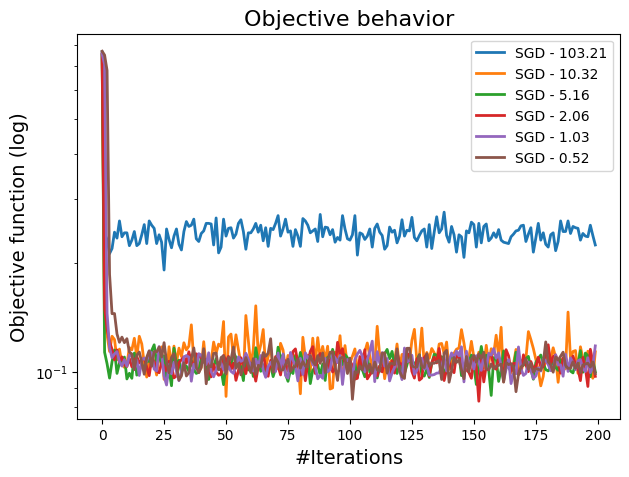

In [22]:
plt.figure(figsize=(7, 5))
for k,v in sgd_results_dict.items():
    plt.semilogy(v[1][:200], label="SGD - %0.2f"%k, lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

With the paralisation of torch, and for the size of our problem, having bigger batches is more conveniant and faster to compute than having small batches because the memory is not a problem.

In [23]:
batch_sizes = [100,500,1000,10000]

sgd_results_dict_per_batch = {}

for batch_size in batch_sizes :
    print("Compute for batch_size %d"%batch_size)
    sgd_results_dict_per_batch[batch_size] = gd_loop(x0,5/L,n_iter=700,batch_size=batch_size,verbose=False)
    print("Final objective value for step - %0.2f"%step,sgd_results_dict_per_batch[batch_size][1][-1])

Compute for batch_size 100


100%|██████████| 700/700 [01:22<00:00,  8.49it/s]


Final objective value for step - 0.52 0.13879866898059845
Compute for batch_size 500


100%|██████████| 700/700 [00:36<00:00, 19.34it/s]


Final objective value for step - 0.52 0.08885764330625534
Compute for batch_size 1000


100%|██████████| 700/700 [00:29<00:00, 24.06it/s]


Final objective value for step - 0.52 0.10441293567419052
Compute for batch_size 10000


100%|██████████| 700/700 [00:22<00:00, 31.26it/s]

Final objective value for step - 0.52 0.10565468668937683


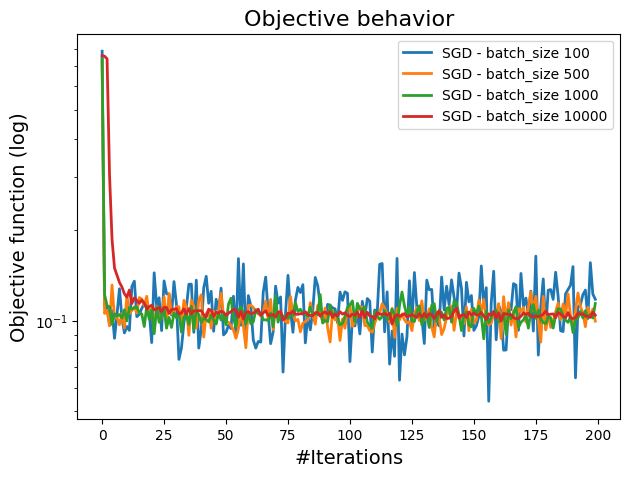

In [24]:
plt.figure(figsize=(7, 5))
for k,v in sgd_results_dict_per_batch.items():
    plt.semilogy(v[1][:200], label="SGD - batch_size %d"%k, lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

best_sgd = sgd_results_dict_per_batch[1000]

We think that a batch size of 1000 with a stepsize of $1/L$ gives the best results. Let's compare it with the best GD above.

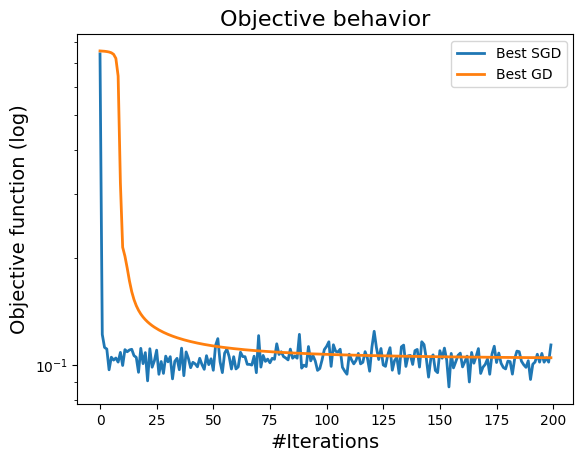

In [25]:
plt.semilogy(best_sgd[1][:200], label="Best SGD", lw=2)
plt.semilogy(best_gd[1][:200], label="Best GD", lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

## <span style="color:rgb(11, 55, 199)"> Question 5 (Adagrad)</span>

Like in the Lab session we updated the gd_loop to include scaling for Adagrad.

In [26]:
#x0 = torch.rand(A.shape[1],requires_grad=False)
steps = [100/L,10/L,5/L,2/L,1/L,0.5/L]

ada_results_dict = {}

for step in steps :
    print("Compute for step %0.2f"%step)
    ada_results_dict[step] = gd_loop(x0,step,n_iter=700,scaling=True,verbose=False)
    print("Final objective value for step - %0.2f"%step,ada_results_dict[step][1][-1])

Compute for step 103.21


100%|██████████| 700/700 [00:12<00:00, 54.22it/s]


Final objective value for step - 103.21 0.24080955982208252
Compute for step 10.32


100%|██████████| 700/700 [00:09<00:00, 71.12it/s]


Final objective value for step - 10.32 0.24080955982208252
Compute for step 5.16


100%|██████████| 700/700 [00:08<00:00, 83.47it/s]


Final objective value for step - 5.16 0.24080918729305267
Compute for step 2.06


100%|██████████| 700/700 [00:07<00:00, 93.37it/s]


Final objective value for step - 2.06 0.10828164219856262
Compute for step 1.03


100%|██████████| 700/700 [00:08<00:00, 82.83it/s]


Final objective value for step - 1.03 0.10361950844526291
Compute for step 0.52


100%|██████████| 700/700 [00:07<00:00, 93.11it/s]

Final objective value for step - 0.52 0.10377530753612518


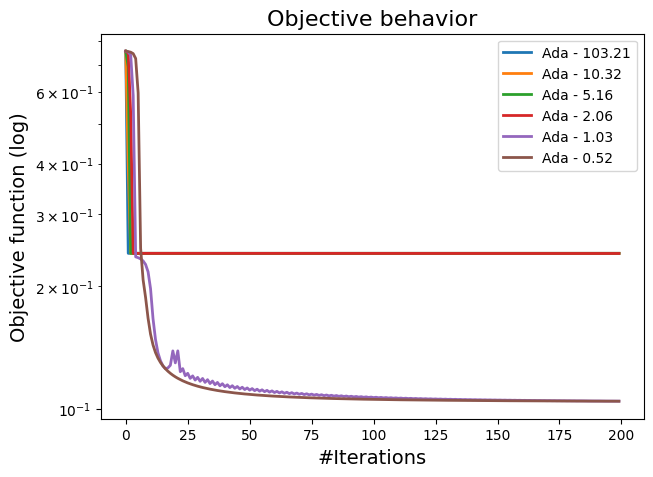

In [27]:
plt.figure(figsize=(7, 5))
for k,v in ada_results_dict.items():
    plt.semilogy(v[1][:200], label="Ada - %0.2f"%k, lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

best_ada = ada_results_dict[1/L]

The best step size seems to be $1/L$, it's in term of performance worse than the best SGD, but better than GD.

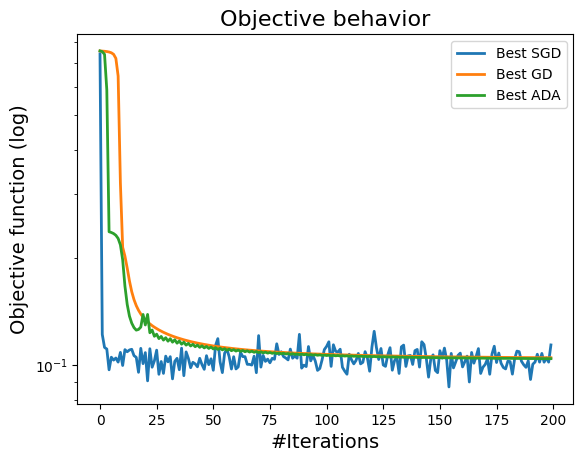

In [28]:
plt.semilogy(best_sgd[1][:200], label="Best SGD", lw=2)
plt.semilogy(best_gd[1][:200], label="Best GD", lw=2)
plt.semilogy(best_ada[1][:200], label="Best ADA", lw=2)

plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

## <span style="color:rgb(11, 55, 199)"> Question 6 (L1-regularized version)</span>

We implemented, the Iterative Soft-Thresholding Algorithm, since it's just an additional step on top of GD step, we included it as an option in gd_loop with $\lambda$ as parameter.

With $\lambda = 0.005$, we have a descent result with only 15 non-zero parameters (very compact !).

A value closer to 0, will lead to similar results than GD but less sparcity. 0.005 seems to be a good tradeoff.

In [29]:
x_sparse, objvals_reg, ngvals_reg = gd_loop(x0,step,n_iter=700,l1_reg = 0.005,batch_size=None,verbose=False)

100%|██████████| 700/700 [00:12<00:00, 56.24it/s]


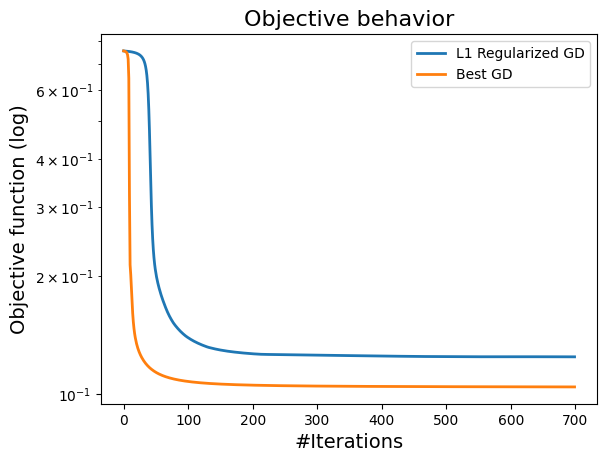

The model from GD have 123 non-zero parameters out of 123
The model from reg GD have 14 non-zero parameters out of 123


In [30]:
plt.semilogy(objvals_reg[:700], label="L1 Regularized GD", lw=2)
plt.semilogy(best_gd[1][:700], label="Best GD", lw=2)

plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

eps = 1e-6
print("The model from GD have",(torch.abs(best_gd[0])>eps).sum().item(),"non-zero parameters out of",len(best_gd[0]))
print("The model from reg GD have",(torch.abs(x_sparse)>eps).sum().item(),"non-zero parameters out of",len(best_gd[0]))

# <span style="color:rgb(199,21,11)">Part 4 - Quasi-Newton techniques</span>

## <span style="color:rgb(11, 55, 199)"> Question 7 (BFGS)</span>

Here is an implementation of BFGS :

In [48]:
def bfgs_loop(x0,stepsize, n_iter=1000, batch_size=None,l1_reg = None,verbose=False):

    ############
    # Initialization

    # History of function values
    objvals = []

    # History of gradient norms
    ngvals = []

    # Initial value of the incumbent, a.k.a. current iterate
    x = x0.clone()
    n = A.shape[0]
    d = A.shape[1]
    eps=1/(2 *(n**0.5))

    # Initial function value
    if batch_size :
        batch_i = np.random.choice(n,batch_size).tolist()
        A_b,y_b = A[batch_i],y[batch_i]
    else :
        A_b,y_b = A,y

    obj = f(x,A_b,y_b)
    objvals.append(obj.item())

    # Initial gradient
    g = gradient_f(x,A_b,y_b)
    ng = torch.norm(g)
    ngvals.append(ng)

    H = torch.eye(d)

    # Plot initial values
    if verbose:
        print("Gradient descent:")
        print(' | '.join([name.center(8) for name in ["iter","step", "fval","stepsize"]]))

    ####################
    # Main loop
    if verbose : iterator = range(n_iter)
    else : iterator = tqdm(range(n_iter))

    for k in iterator:
        if batch_size : steps = n//batch_size
        else : steps=1
        for l in range(steps):

            x_old = x
            # Perform the gradient descent iteration using the stepsize s and the gradient g
            x = x - stepsize*(H@g)

            if l1_reg :
                for i in range(d):
                    threshold = stepsize*l1_reg
                    if x[i] < -threshold:
                        x[i] = x[i]+threshold
                    elif x[i] > threshold:
                        x[i] = x[i]-threshold
                    else:
                        x[i] = 0

            s = (x-x_old).reshape((d,1))

            # Plot relevant information
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%d" % l).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % stepsize).rjust(8)]))

            # Compute values associated with the next iterate
            if batch_size :
                batch_i = np.random.choice(n,batch_size).tolist()
                A_b,y_b = A[batch_i],y[batch_i]
            else :
                A_b,y_b = A,y
            g_old = g
            g = gradient_f(x,A_b,y_b)
            v = (g-g_old).reshape((d,1))

            denom = s.T@v

            if denom>eps :
                vs = (v@s.T)/denom
                ss = (s@s.T)/denom
                tvs = (torch.eye(d) - vs)
                H = tvs @ H @ tvs + ss

        obj = f(x,A_b,y_b)
        ng = torch.norm(g)
        objvals.append(obj.item())
        ngvals.append(ng.item())

    # End main loop
    ######################

    # Outputs
    x_output = x.clone()
    return x_output, objvals, ngvals

In [49]:
steps = [5/L,2/L,1/L,0.7/L,0.5/L]

bfgs_results_dict = {}

for step in steps :
    print("Compute for step %0.2f"%step)
    bfgs_results_dict[step] = bfgs_loop(x0,step,n_iter=700,verbose=False)
    print("Final objective value for step - %0.2f"%step,bfgs_results_dict[step][1][-1])

Compute for step 5.16


100%|██████████| 700/700 [00:09<00:00, 74.03it/s]


Final objective value for step - 5.16 0.24080955982208252
Compute for step 2.06


100%|██████████| 700/700 [00:09<00:00, 77.76it/s]


Final objective value for step - 2.06 0.24080955982208252
Compute for step 1.03


100%|██████████| 700/700 [00:08<00:00, 85.99it/s]


Final objective value for step - 1.03 0.10590974241495132
Compute for step 0.72


100%|██████████| 700/700 [00:08<00:00, 79.54it/s]


Final objective value for step - 0.72 0.10748385637998581
Compute for step 0.52


100%|██████████| 700/700 [00:08<00:00, 81.07it/s]

Final objective value for step - 0.52 0.10981892794370651


Gradient decent performs better.

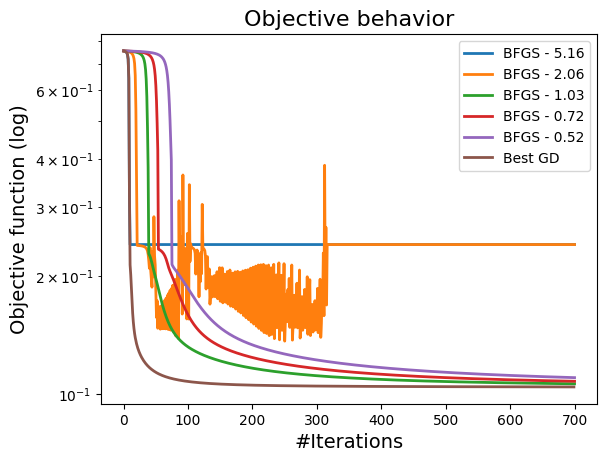

In [52]:
for k,v in bfgs_results_dict.items():
    plt.semilogy(v[1], label="BFGS - %0.2f"%k, lw=2)

plt.semilogy(best_gd[1][:700], label="Best GD", lw=2)

plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

best_bfgs = bfgs_results_dict[1/L]

## <span style="color:rgb(11, 55, 199)"> Question 8 (stochastic BFGS)</span>

We use the same f and gradient_f function than before, so it works seemlessly with batches. However it performs poorly.

In [51]:
steps = [1/L,0.7/L,0.5/L]

sbfgs_results_dict = {}

for step in steps :
    print("Compute for step %0.2f"%step)
    sbfgs_results_dict[step] = bfgs_loop(x0,step,n_iter=700,batch_size=20000,verbose=False)
    print("Final objective value for step - %0.2f"%step,sbfgs_results_dict[step][1][-1])

Compute for step 1.03


100%|██████████| 700/700 [00:17<00:00, 38.89it/s]


Final objective value for step - 1.03 0.10759851336479187
Compute for step 0.72


100%|██████████| 700/700 [00:18<00:00, 37.65it/s]


Final objective value for step - 0.72 0.10901987552642822
Compute for step 0.52


100%|██████████| 700/700 [00:19<00:00, 35.24it/s]

Final objective value for step - 0.52 0.11036970466375351


The best SGD performs better than the best BFGS.

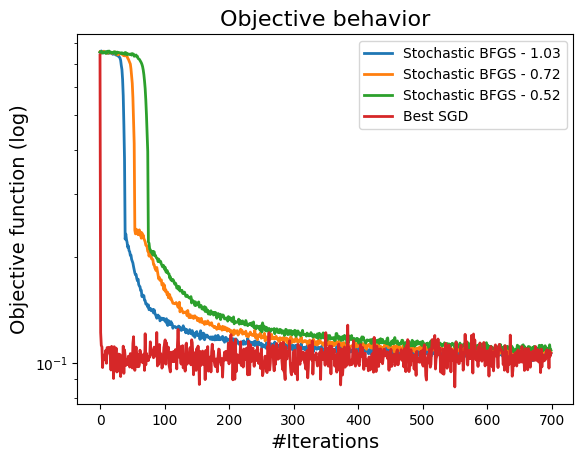

In [54]:
for k,v in sbfgs_results_dict.items():
    plt.semilogy(v[1][:700], label="Stochastic BFGS - %0.2f"%k, lw=2)

plt.semilogy(best_sgd[1][:700], label="Best SGD", lw=2)

plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

## <span style="color:rgb(11, 55, 199)"> Question 9 (stochastic BFGS vs Adagrad)</span>

In BFGS, we update H (dxd matrix), and s (d vector) and v (d vector), while doing matrix multiplication to update H and for the gradient step, while in Adagrad, we only update a scaling vector with d sum and d multiplication, for more details on the number of operations needed, we can see the result of the profiler below of both BFGS and Adagrad

In [55]:
import torch.autograd.profiler as profiler

with profiler.profile(with_flops=True) as prof:
    result = bfgs_loop(x0,1/L,n_iter=15,batch_size=1000,verbose=False)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

100%|██████████| 15/15 [00:01<00:00, 11.78it/s]


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  Total MFLOPs  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::index        43.78%     283.633ms        45.13%     292.365ms     303.914us           962            --  
                    aten::mul        13.95%      90.354ms        16.86%     109.191ms      45.120us          2420        60.681  
                 aten::matmul         1.47%       9.524ms        11.51%      74.545ms      50.335us          1481            --  
                   aten::mean         1.19%       7.685ms         8.41%      54.497ms     109.651us           497            --  
                     aten::mv         1.52%       9.839ms         8.07%      52.305ms     

In [56]:
with profiler.profile(with_flops=True) as prof:
    result = gd_loop(x0,1/L,n_iter=15,scaling=True,verbose=False)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

100%|██████████| 15/15 [00:00<00:00, 40.58it/s]

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  Total MFLOPs  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    aten::mul        28.25%      58.202ms        28.59%      58.896ms     535.419us           110        66.168  
                    aten::neg        23.47%      48.363ms        23.47%      48.363ms       1.511ms            32            --  
                 aten::matmul         0.12%     237.771us        23.17%      47.727ms       1.491ms            32            --  
                     aten::mv         0.32%     651.767us        23.05%      47.489ms       1.484ms            32            --  
                 aten::addmv_        22.59%      46.539ms        22.59%      46.539ms     

## <span style="color:rgb(11, 55, 199)"> Question 10 (L1 regularized BFGS)</span>

In [57]:
x_sparse_b, objvals_reg_b, ngvals_reg_b = bfgs_loop(x0,0.7/L,n_iter=700,l1_reg = 0.01,batch_size=None,verbose=False)

100%|██████████| 700/700 [00:13<00:00, 53.01it/s]


The method is generalizable, and it's provide decent results

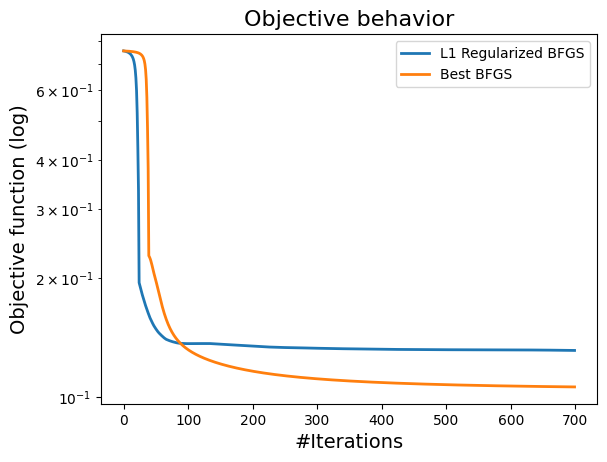

The model from BFGS have tensor(123) non-zero parameters out of 123
The model from reg BFGS have tensor(6) non-zero parameters out of 123


In [58]:
plt.semilogy(objvals_reg_b[:700], label="L1 Regularized BFGS", lw=2)
plt.semilogy(best_bfgs[1][:700], label="Best BFGS", lw=2)

plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

eps = 1e-6
print("The model from BFGS have",(torch.abs(best_bfgs[0])>eps).sum(),"non-zero parameters out of",len(best_bfgs[0]))
print("The model from reg BFGS have",(torch.abs(x_sparse_b)>eps).sum(),"non-zero parameters out of",len(best_bfgs[0]))

## <span style="color:rgb(11, 55, 199)"> Question 11 (L-BFGS)</span>

In [59]:
def lbfgs_loop(x0,stepsize, n_iter=1000, memory = 5,l1_reg=None,batch_size=None,verbose=False):

    ############
    # Initialization

    # History of function values
    objvals = []

    # History of gradient norms
    ngvals = []

    # Initial value of the incumbent, a.k.a. current iterate
    x = x0.clone()
    n = A.shape[0]
    d = A.shape[1]
    eps=1/(2 *(n ** (0.5)))


    # Initial function value
    if batch_size :
        batch_i = np.random.choice(n,batch_size).tolist()
        A_b,y_b = A[batch_i],y[batch_i]
    else :
        A_b,y_b = A,y

    obj = f(x,A_b,y_b)
    objvals.append(obj.item())

    # Initial gradient
    g = gradient_f(x,A_b,y_b)
    ng = torch.norm(g)
    ngvals.append(ng)

    S = torch.zeros((memory,g.shape[0]))
    V = torch.zeros((memory,g.shape[0]))

    # Plot initial values
    if verbose:
        print("Gradient descent:")
        print(' | '.join([name.center(8) for name in ["iter","step","fval","stepsize"]]))

    ####################
    # Main loop
    if verbose : iterator = range(n_iter)
    else : iterator = tqdm(range(n_iter))

    for k in iterator:
        if batch_size : p = n//batch_size
        else : p=1
        for l in range(p):
            pos = k*n_iter+l
            x_old = x

            q = g.clone()
            denom = (S*V).sum(axis=1)
            denom_mask = denom>eps

            # Loop 1
            gamma = (S@q)[denom_mask]/denom[denom_mask]
            gamma = gamma.unsqueeze(dim=1)
            v = V[denom_mask]
            if denom_mask.sum()>0 :
                gv = (gamma*v).sum(axis=0)
                q-=gv

            # Loop 2
            delta = (V@q)[denom_mask]/denom[denom_mask]
            delta = delta.unsqueeze(dim=1)
            s = S[denom_mask]
            if denom_mask.sum()>0 :
                gs = ((gamma-delta)*s).sum(axis=0)
                q+=gs

            x = x - stepsize*q
            if l1_reg :
                for i in range(d):
                    threshold = stepsize*l1_reg
                    if x[i] < -threshold:
                        x[i] = x[i]+threshold
                    elif x[i] > threshold:
                        x[i] = x[i]-threshold
                    else:
                        x[i] = 0

            s = (x-x_old).reshape((d,1))

            # Plot relevant information
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%d" % l).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % stepsize).rjust(8)]))

            # Compute values associated with the next iterate
            if batch_size :
                batch_i = np.random.choice(n,batch_size).tolist()
                A_b,y_b = A[batch_i],y[batch_i]
            else :
                A_b,y_b = A,y
            g_old = g
            g = gradient_f(x,A_b,y_b)
            v = (g-g_old).reshape((d,1))

            S[pos%memory]=s.squeeze()
            V[pos%memory]=v.squeeze()

        obj = f(x,A_b,y_b)
        ng = torch.norm(g)
        objvals.append(obj.item())
        ngvals.append(ng.item())

    # End main loop
    ######################

    # Outputs
    x_output = x.clone()
    return x_output, objvals, ngvals

The L-BFGS is computationally faster while keeping close results.





In [60]:
steps = [1/L,0.7/L,.5/L]
memories = [5,10]
lbfgs_results_dict = {}

for step in steps :
    for memory in memories :
        print("Compute for step %0.2f memory %d"%(step,memory))
        lbfgs_results_dict[(step,memory)] = lbfgs_loop(x0,step,memory = memory,n_iter=700,verbose=False)
        print("Final objective value for step - %0.2f"%step,lbfgs_results_dict[(step,memory)][1][-1])

Compute for step 1.03 memory 5


100%|██████████| 700/700 [00:09<00:00, 74.94it/s]


Final objective value for step - 1.03 0.1061474084854126
Compute for step 1.03 memory 10


100%|██████████| 700/700 [00:09<00:00, 75.97it/s]


Final objective value for step - 1.03 0.1061474084854126
Compute for step 0.72 memory 5


100%|██████████| 700/700 [00:09<00:00, 72.62it/s]


Final objective value for step - 0.72 0.11154425889253616
Compute for step 0.72 memory 10


100%|██████████| 700/700 [00:09<00:00, 70.57it/s]


Final objective value for step - 0.72 0.11154425889253616
Compute for step 0.52 memory 5


100%|██████████| 700/700 [00:08<00:00, 79.31it/s]


Final objective value for step - 0.52 0.10947202146053314
Compute for step 0.52 memory 10


100%|██████████| 700/700 [00:09<00:00, 73.81it/s]

Final objective value for step - 0.52 0.10947202146053314


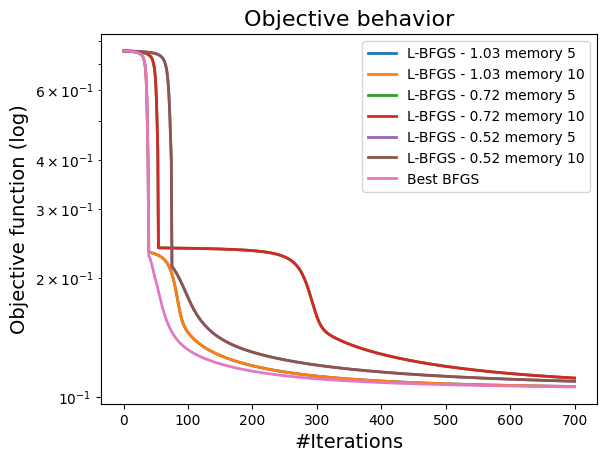

In [72]:
for k,v in lbfgs_results_dict.items():
   plt.semilogy(v[1], label="L-BFGS - %0.2f memory %d"%k, lw=2)
plt.semilogy(best_bfgs[1], label="Best BFGS", lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

best_lbfgs = lbfgs_results_dict[1/L,10]

## <span style="color:rgb(11, 55, 199)"> Question 12 (L-BFGS)</span>

### <span style="color:rgb(0, 0, 0)"> Question 12 (Q8 - Stochastic L-BFGS)</span>

In [74]:
steps = [1/L,0.5/L]
memories = [10]
slbfgs_results_dict = {}

for step in steps :
    for memory in memories :
        print("Compute for step %0.2f memory %d"%(step,memory))
        slbfgs_results_dict[(step,memory)] = lbfgs_loop(x0,step,memory = memory,n_iter=700,batch_size=10000,verbose=False)
        print("Final objective value for step - %0.2f"%step,slbfgs_results_dict[(step,memory)][1][-1])

Compute for step 1.03 memory 10


100%|██████████| 700/700 [00:26<00:00, 25.93it/s]


Final objective value for step - 1.03 0.10744135826826096
Compute for step 0.52 memory 10


100%|██████████| 700/700 [00:29<00:00, 23.96it/s]

Final objective value for step - 0.52 0.10286657512187958


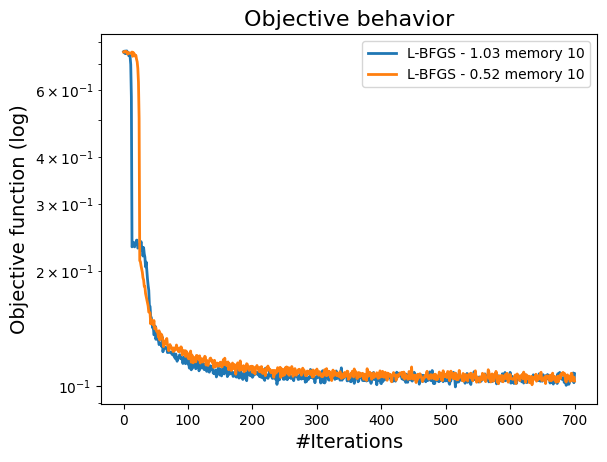

In [75]:
for k,v in slbfgs_results_dict.items():
    plt.semilogy(v[1], label="L-BFGS - %0.2f memory %d"%k, lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

### <span style="color:rgb(0, 0, 0)"> Question 12 (Q9 - L-BFGS vs Ada)</span>

Computationally we still do more than Ada, however taking all the matrix updates and multiplication, we reduce drastically the number of operation and we get closer to Adagrad.

In [76]:
import torch.autograd.profiler as profiler

with profiler.profile(with_flops=True) as prof:
    result = lbfgs_loop(x0,1/L,n_iter=15,verbose=False)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

100%|██████████| 15/15 [00:00<00:00, 64.84it/s]


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  Total MFLOPs  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    aten::mul        26.14%      55.804ms        26.49%      56.543ms     514.024us           110        66.175  
                 aten::matmul         0.15%     318.834us        23.52%      50.195ms     809.604us            62            --  
                     aten::mv         0.48%       1.033ms        23.37%      49.877ms     804.461us            62            --  
                 aten::addmv_        22.70%      48.454ms        22.70%      48.454ms     781.511us            62            --  
                    aten::neg        22.02%      46.991ms        22.02%      46.991ms     

### <span style="color:rgb(0, 0, 0)"> Question 12 (Q10 - L1 Reg L-BFGS)</span>

In [73]:
x_sparse_lb, objvals_reg_b, ngvals_reg_lb = lbfgs_loop(x0,1/L,n_iter=700,memory=10,l1_reg = 0.01,batch_size=None,verbose=False)

100%|██████████| 700/700 [00:13<00:00, 52.09it/s]


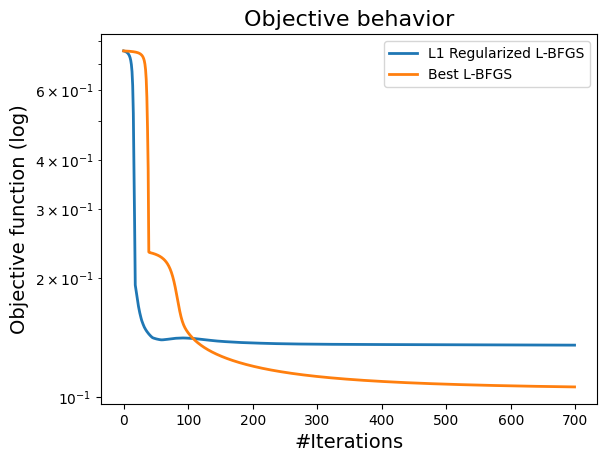

The model from L-BFGS have tensor(123) non-zero parameters out of 123
The model from reg L-BFGS have tensor(6) non-zero parameters out of 123


In [77]:
plt.semilogy(objvals_reg_b[:700], label="L1 Regularized L-BFGS", lw=2)
plt.semilogy(best_lbfgs[1][:700], label="Best L-BFGS", lw=2)

plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()
plt.show()

eps = 1e-6
print("The model from L-BFGS have",(torch.abs(best_lbfgs[0])>eps).sum(),"non-zero parameters out of",len(best_lbfgs[0]))
print("The model from reg L-BFGS have",(torch.abs(x_sparse_lb)>eps).sum(),"non-zero parameters out of",len(best_lbfgs[0]))